In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop

import lightgbm as lgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tqdm import tqdm
import os

In [3]:

data = pd.read_csv('features_6.csv')
X = data.iloc[: ,:-2].values
y = data['labels'].values


maping = {'angry': 5,
 'calm': 3,
 'disgust': 2,
 'fear': 0,
 'happy': 1,
 'neutral': 7,
 'sad': 4,
 'surprise': 6}

train_y = []
for i in y:
    train_y.append(maping[i])

train_y = np.array(train_y)

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, train_y, test_size=0.2, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

labels_train_y = to_categorical(y_train)
labels_test_y = to_categorical(y_test)

/Users/grigorkeropyan/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (163) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(x_train.shape, x_test.shape)

(13568, 162) (3392, 162)


In [5]:
clf = LGBMClassifier(boosting_type='gbdt', objective='multiclass',
                     learning_rate=0.42352561266844885,
                     max_depth= 70,
                     n_estimators=160)

In [6]:
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print('model accuracy is {} '
      .format((pred == y_test).sum()/y_test.size))

model accuracy is 0.9516509433962265 


In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    #data with shift
    shft_data = shift(data)
    res4 = extract_features(shft_data)
    result = np.vstack((result, res4))
    
    return result



In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [10]:
data, sample_rate = librosa.load('my_recording.wav', duration=2.5, offset=0.6)

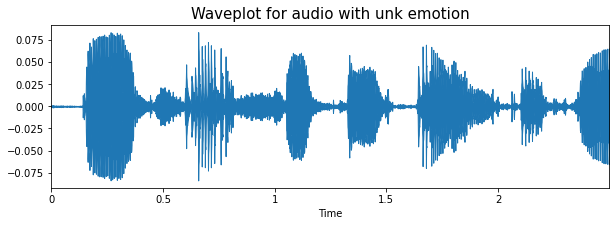

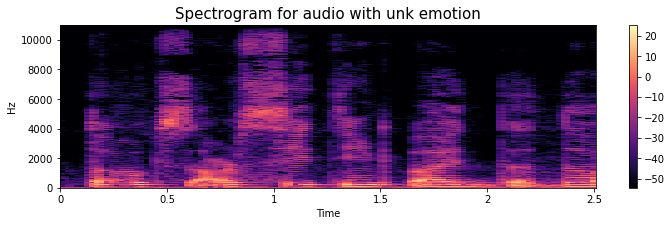

In [11]:
create_waveplot(data, sample_rate, "unk")
create_spectrogram(data, sample_rate, "unk")
Audio('my_recording.wav')

In [15]:
my_data = extract_features(data).reshape((1, 162))

In [16]:
my_data.shape

(1, 162)

In [17]:
clf.predict(my_data)

array([2])